In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, concatenate, SeparableConv2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

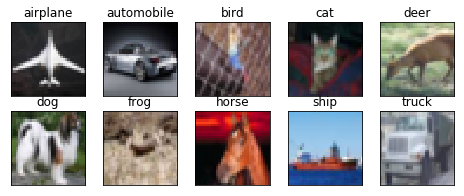

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def CIFAR():
  
    inputs = Input(shape=(32,32,3))

    #Normal Convolution
    x1 = Convolution2D(32, 3,3,activation='relu',name="conv1",border_mode='same')(inputs) # 32 receptive field = 3
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.12)(x1)

    #Spatially Separable Convolution
    x2 = Convolution2D(32, (3,1),activation='relu',name="conv2",border_mode='same')(x1) 
    x2 = BatchNormalization()(x2)

    x3 = Convolution2D(32, (1,3),activation='relu',name="conv3",border_mode='same')(x2)# 32 receptive field=5
    x3 = BatchNormalization()(x3)

    x4 = concatenate([x1,x2,x3])

    x4 = Convolution2D(16, (1,1),activation='relu', name="conv3_1",border_mode='same')(x4)
    x4 = BatchNormalization()(x4)


    x5 = Convolution2D(64, (3,3),activation='relu',name="conv4",border_mode='same')(x4) #32 receptive field = 7
    x5 = BatchNormalization()(x5)
    x5 = Dropout(0.12)(x5)

    #depth wise seperable convolution
    x6 = SeparableConv2D(64, (3,3), activation='relu',name="conv5", border_mode='same')(x5) #32 receptive field = 9
    x6 = BatchNormalization()(x6)
    x6 = Dropout(0.12)(x6)
 
    #transition block
    x7 = MaxPooling2D(pool_size=(2,2),strides=(2,2),border_mode='valid',name='pool1')(x6) # 16 receptive field = 18
    x8 = Convolution2D(16, (1,1),activation='relu', name="conv5_1",border_mode='same')(x7)
    x8 = BatchNormalization()(x8)

    #grouped convolution (3X3) and (5X5)
    x9 = Convolution2D(64, (3,3),activation='relu',name="conv6",border_mode='same')(x8) #16 receptive field = 20
    x9 = BatchNormalization()(x9)

    x10 = Convolution2D(64, (5,5),activation='relu',name="conv7",border_mode='same')(x8) #16 receptive field = 22
    x10 = BatchNormalization()(x10)

    x11 = concatenate([x9,x10])
    x11 = Dropout(0.12)(x11)

    #transition block
    x12 = MaxPooling2D(pool_size=(2,2),strides=(2,2),border_mode='valid',name='pool2')(x11) #8 receptive field = 44
    x13 = Convolution2D(16, (1,1),activation='relu', name="conv7_1",border_mode='same')(x12)
    x13 = BatchNormalization()(x13)

    #dialated convolution with dilation rate=1 
    x14 = Convolution2D(64, (3,3), dilation_rate=1, activation='relu', name="conv8",border_mode='same')(x13)#8 receptive field = 46
    x14 = BatchNormalization()(x14)
    x14 = Dropout(0.12)(x14)

    x14_1 = Convolution2D(16, (1,1),activation='relu', name="conv8_1",border_mode='same')(x14)
    x14_1 = BatchNormalization()(x14_1)

    #dialated convolution with dilation rate=2
    x15 = Convolution2D(128, (3,3), dilation_rate=2, activation='relu', name="conv9",border_mode='same')(x14_1)#8 receptive field = 48
    x15 = BatchNormalization()(x15)
    x15 = Dropout(0.12)(x15)
 
    #transition block
    x16 = MaxPooling2D(pool_size=(2,2),strides=(2,2),border_mode='valid',name='pool3')(x15) #4 receptive field = 96
    x17 = Convolution2D(16, (1,1),activation='relu', name="conv9_1",border_mode='same')(x16) 
    x17 = BatchNormalization()(x17)

    x18 = Convolution2D(64, (3,3),activation='relu',name="conv10",border_mode='same')(x17) #4 receptive field = 98
    x18 = BatchNormalization()(x18)

    x18_1 = Convolution2D(16, (1,1),activation='relu', name="conv10_1",border_mode='same')(x18)
    x18_1 = BatchNormalization()(x18_1)

    x19 = Convolution2D(128, (3,3),activation='relu',name="conv11",border_mode='same')(x18_1) #4 receptive field =100

    x20 = Convolution2D(10, (4,4))(x19)
    predictions = Flatten()(x20)
    output = Activation('softmax',name='prob')(predictions)
    model = Model(inputs=inputs, outputs=output)

    print(model.summary())
    return model


In [14]:
model = CIFAR()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2 (Con

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 29s 75ms/step - loss: 1.4881 - acc: 0.4545 - val_loss: 2.8763 - val_acc: 0.3661
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 24s 62ms/step - loss: 1.0465 - acc: 0.6210 - val_loss: 1.0782 - val_acc: 0.6274
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 24s 61ms/step - loss: 0.8627 - acc: 0.6915 - val_loss: 0.8859 - val_acc: 0.6795
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 24s 61ms/step - loss: 0.7522 - acc: 0.7310 - val_loss: 0.8339 - val_acc: 0.7013
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 24s 61ms/step - loss: 0.6705 - acc: 0.7601

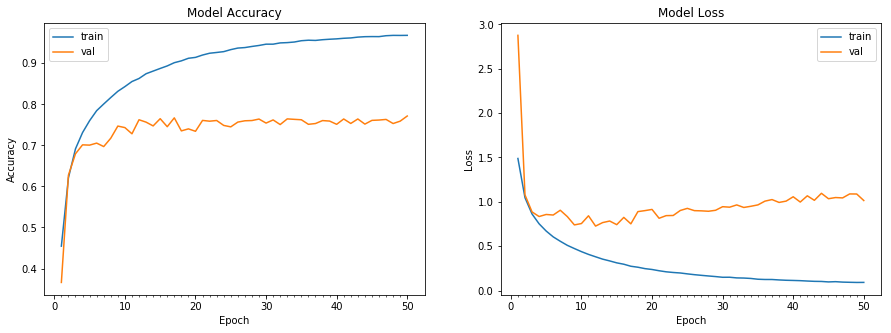

Accuracy on test data is: 77.15


In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50,
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1)], 
                                 validation_data = (test_features, test_labels),verbose=1)                             
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))